(please do pip install -r requirements.txt)

In [2]:
import pandas as pd
import numpy as np

In [3]:
train = pd.read_csv("dataset/train.csv")
test  = pd.read_csv("dataset/test.csv")
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)
train['source'] = 'train'
test ['source'] = 'test'
df = pd.concat([train, test])

In [4]:
target   = 'song_popularity'
features = test.columns.drop('source')
continous_columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence']

None value amputation

In [5]:
for column in df.columns:
    if column in ('source', 'song_popularity'):
        continue
    if column in continous_columns:
        median = df.loc[df['source'] == 'train', column].median()
        print(column, median)
        df[column].fillna(median, inplace=True)
    else:
        mode = df.loc[df['source'] == 'test', column].mode()[0]
        print(column, mode)
        df[column].fillna(mode, inplace=True)

song_duration_ms 161760.0
acousticness 0.14053234888623756
danceability 0.6082338355736929
energy 0.7044533182633863
instrumentalness 0.0019744766301669
key 0.0
liveness 0.13594518271937028
loudness -6.345412615480568
audio_mode 0
speechiness 0.0558807732613924
tempo 113.79595942988647
time_signature 3
audio_valence 0.5988269955094705


In [6]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(df[df['source'] == 'train'].drop(['source', target], axis=1), df[df['source'] == 'train'][target], random_state=1, train_size=0.8)

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
'''
utility function for testing models
'''
def test_model(model, testX, testY):
    preds = model.predict(testX)
    preds = np.where(preds > .5, 1, 0)
    print(classification_report(testY, preds))
    ConfusionMatrixDisplay.from_predictions(testY, preds)    

In [8]:
from functools import cache

'''
getting the VIF of each column

inspired by https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
'''
@cache     # for not calculating the vif each time we require it
def get_vif_columns(): 
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    vif_data = pd.DataFrame()
    vif_data["features"] = trainX.columns
    
    vif_data['VIF'] = [variance_inflation_factor(trainX.values, i) for i in range(len(trainX.columns))]

    return vif_data

In [9]:
import imblearn  # for oversampling minority class

@cache  # caching for avoiding retraining
def oversample():
    ros = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
    return ros.fit_resample(trainX, trainY)

              precision    recall  f1-score   support

         0.0       0.63      1.00      0.78      5074
         1.0       0.67      0.00      0.00      2926

    accuracy                           0.63      8000
   macro avg       0.65      0.50      0.39      8000
weighted avg       0.65      0.63      0.49      8000



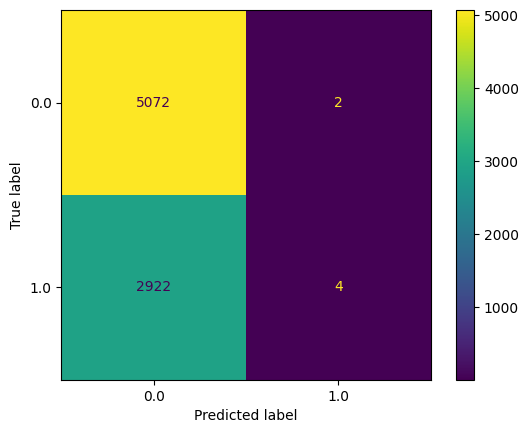

In [10]:
'''
Just Logistic Regression with scaling
'''

def model1():
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    
    scaler = StandardScaler().fit(trainX)
    model  = LogisticRegression().fit(scaler.transform(trainX), trainY)
    
    
    test_model(model, scaler.transform(testX), testY)

model1()

Highly biased model

              precision    recall  f1-score   support

         0.0       0.64      0.95      0.76      5074
         1.0       0.45      0.07      0.12      2926

    accuracy                           0.63      8000
   macro avg       0.54      0.51      0.44      8000
weighted avg       0.57      0.63      0.53      8000



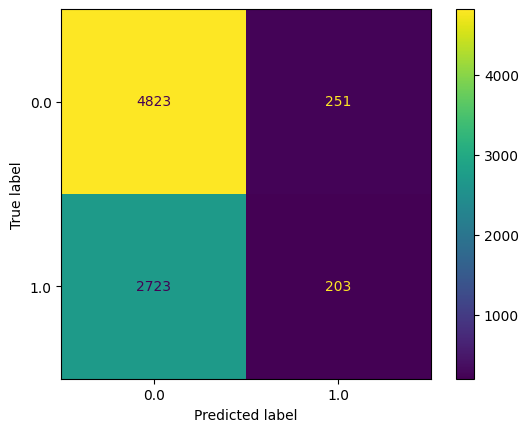

In [16]:
'''
RandomForest With scaling
'''

def model2():
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    
    scaler = StandardScaler().fit(trainX)
    model  = RandomForestClassifier().fit(scaler.transform(trainX), trainY)
    
    
    test_model(model, scaler.transform(testX), testY)

model2()

better than model1 but still biased

{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.63      1.00      0.78      5074
         1.0       0.22      0.00      0.00      2926

    accuracy                           0.63      8000
   macro avg       0.43      0.50      0.39      8000
weighted avg       0.48      0.63      0.49      8000



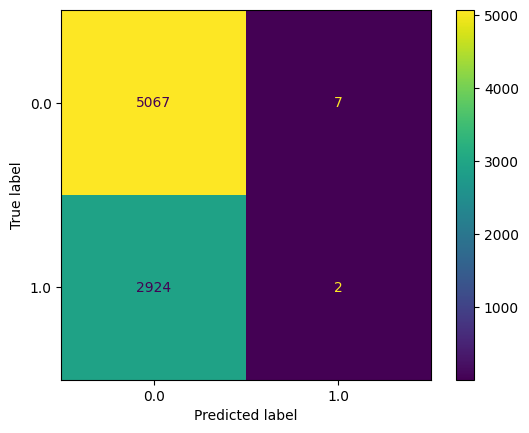

In [21]:
'''
Random Forest grid search with scaling
'''

def model3():
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    
    scaler = StandardScaler().fit(trainX)
    rfc  = RandomForestClassifier()
    
    param_grid = { 
        'n_estimators': [200, 300],
        'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy']
    }
    
    clf = GridSearchCV(estimator = rfc, param_grid=param_grid, cv = 5).fit(scaler.transform(trainX), trainY)
    
    print(clf.best_params_)
    
    test_model(clf, scaler.transform(testX), testY)

model3()

Biased

/home/sivansh/programming/automation-ai/assignment-1/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sivansh/programming/automation-ai/assignment-1/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sivansh/programming/automation-ai/assignment-1/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

              precision    recall  f1-score   support

         0.0       0.63      1.00      0.78      5074
         1.0       0.00      0.00      0.00      2926

    accuracy                           0.63      8000
   macro avg       0.32      0.50      0.39      8000
weighted avg       0.40      0.63      0.49      8000



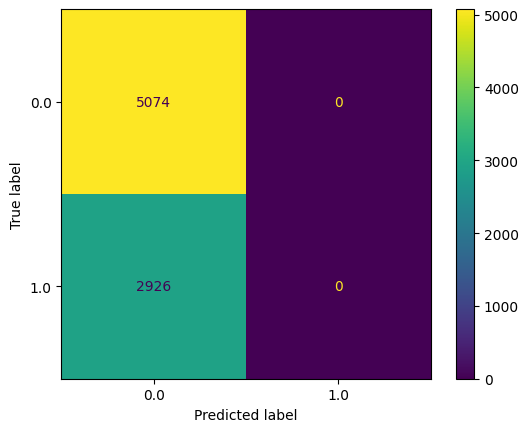

In [52]:
'''
Logistic regression with scaling and removal of columns with high varience inflation factor
'''

def model4():
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    
    vif_df = get_vif_columns()
    
    trainXCpy = trainX.copy()
    trainXCpy.drop(vif_df.loc[vif_df['VIF'] < 5]['features'].values, axis=1, inplace=True)
    testXCpy = testX.copy()
    testXCpy.drop(vif_df.loc[vif_df['VIF'] < 5]['features'].values, axis=1, inplace=True)
    scaler = StandardScaler().fit(trainXCpy)
    
    model  = LogisticRegression().fit(scaler.transform(trainXCpy), trainY)
    
    test_model(model, scaler.transform(testXCpy), testY)

model4()

              precision    recall  f1-score   support

         0.0       0.64      0.92      0.75      5074
         1.0       0.41      0.10      0.16      2926

    accuracy                           0.62      8000
   macro avg       0.52      0.51      0.46      8000
weighted avg       0.56      0.62      0.54      8000



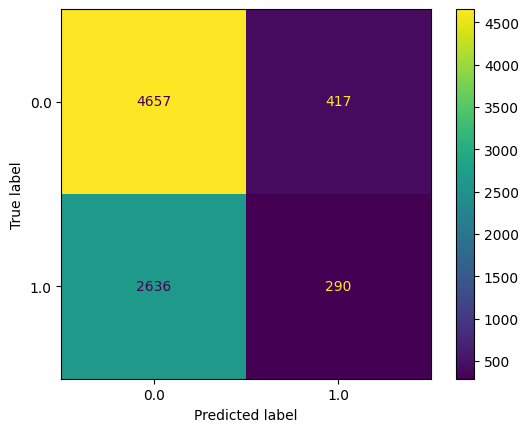

In [50]:
'''
Random forest with scaling and removal of columns with high varience inflation factor
'''

def model5():
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    
    vif_df = get_vif_columns()
    
    trainXCpy = trainX.copy()
    trainXCpy.drop(vif_df.loc[vif_df['VIF'] < 5]['features'].values, axis=1, inplace=True)
    testXCpy = testX.copy()
    testXCpy.drop(vif_df.loc[vif_df['VIF'] < 5]['features'].values, axis=1, inplace=True)
    scaler = StandardScaler().fit(trainXCpy)
    
    model  = RandomForestClassifier().fit(scaler.transform(trainXCpy), trainY)
    
    
    test_model(model, scaler.transform(testXCpy), testY)

model5()

a little less biased than model2 but not good overall

              precision    recall  f1-score   support

         0.0       0.64      0.99      0.77      5074
         1.0       0.47      0.01      0.02      2926

    accuracy                           0.63      8000
   macro avg       0.55      0.50      0.40      8000
weighted avg       0.57      0.63      0.50      8000



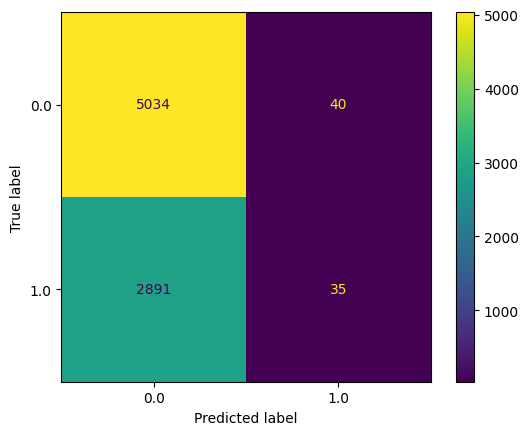

In [53]:
'''
Gradient boosting with scaling
'''

def model6():
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import GradientBoostingClassifier
    
    scaler = StandardScaler().fit(trainX)
    model  = GradientBoostingClassifier().fit(scaler.transform(trainX), trainY)
    
    test_model(model, scaler.transform(testX), testY)

model6()

              precision    recall  f1-score   support

         0.0       0.66      0.55      0.60      5074
         1.0       0.40      0.51      0.44      2926

    accuracy                           0.54      8000
   macro avg       0.53      0.53      0.52      8000
weighted avg       0.56      0.54      0.55      8000



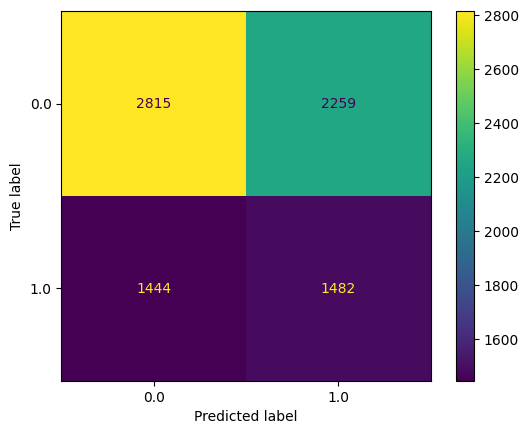

In [14]:
'''
Logistic regression with scaling, removal of columns with high VIF and oversampling of minority class
'''

def model7():
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    
    vif_df = get_vif_columns()
    
    newTrainX, newTrainY = oversample()
    
    trainXCpy = newTrainX.copy()
    trainXCpy.drop(vif_df.loc[vif_df['VIF'] < 5]['features'].values, axis=1, inplace=True)
    testXCpy = testX.copy()
    testXCpy.drop(vif_df.loc[vif_df['VIF'] < 5]['features'].values, axis=1, inplace=True)
    
    scaler = StandardScaler().fit(trainXCpy)
    
    model  = LogisticRegression().fit(scaler.transform(trainXCpy), newTrainY)
    
    test_model(model, scaler.transform(testXCpy), testY)

model7()

Least biased model till now, oversampling with high vif removal 

/home/sivansh/programming/automation-ai/assignment-1/.venv/lib/python3.10/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


250/250 [==============================] - 0s 600us/step
              precision    recall  f1-score   support

         0.0       0.64      0.98      0.77      5074
         1.0       0.45      0.03      0.06      2926

    accuracy                           0.63      8000
   macro avg       0.54      0.50      0.42      8000
weighted avg       0.57      0.63      0.51      8000



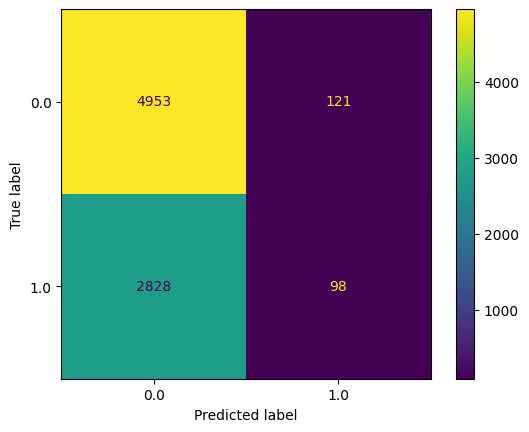

In [20]:
'''
Neural network with scaling
'''

def model8():
    from sklearn.preprocessing import StandardScaler
    from tensorflow import keras as k
    
    trainXCpy = trainX.copy()
    testXCpy = testX.copy()
    scaler = StandardScaler().fit(trainXCpy)
    
    inputs  = k.Input(trainXCpy.shape[1])
    layer   = k.layers.Dense(16, activation="relu")(inputs)
    layer   = k.layers.Dense(16, activation="relu")(layer)
    outputs = k.layers.Dense(1,  activation="sigmoid")(layer)
    model   = k.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

    model.fit(scaler.transform(trainXCpy), trainY, epochs=50, validation_split=0.2, shuffle=False, verbose=0)
    
    test_model(model, scaler.transform(testXCpy), testY)

model8()

250/250 [==============================] - 0s 549us/step
              precision    recall  f1-score   support

         0.0       0.65      0.77      0.71      5074
         1.0       0.42      0.28      0.34      2926

    accuracy                           0.59      8000
   macro avg       0.54      0.53      0.52      8000
weighted avg       0.57      0.59      0.57      8000



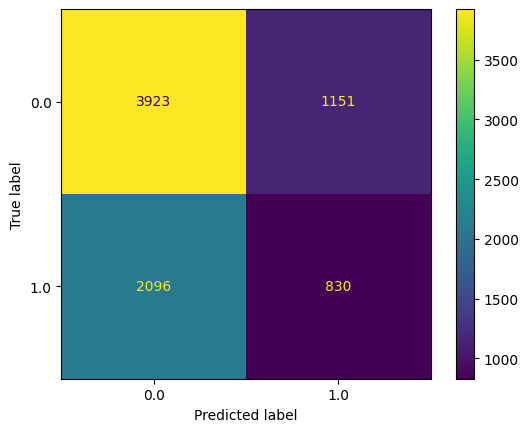

In [21]:
'''
Neural network with scaling and oversampling of minority class
'''

def model9():
    from sklearn.preprocessing import StandardScaler
    from tensorflow import keras as k
    
    newTrainX, newTrainY = oversample()    
    trainXCpy = newTrainX.copy()
    testXCpy = testX.copy()
    scaler = StandardScaler().fit(trainXCpy)
    
    inputs  = k.Input(trainXCpy.shape[1])
    layer   = k.layers.Dense(16, activation="relu")(inputs)
    layer   = k.layers.Dense(16, activation="relu")(layer)
    outputs = k.layers.Dense(1,  activation="sigmoid")(layer)
    model   = k.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

    model.fit(scaler.transform(trainXCpy), newTrainY, epochs=50, validation_split=0.2, shuffle=False, verbose=0)
    
    test_model(model, scaler.transform(testXCpy), testY)

model9()

better than model7